## Dataset

Dataset is from Meetup RSVP streaming API. Each observation is a users response rsvp=yes/no to a certain event hosted by a certain group, which is associated with various tags (called urlkey)

See diagram below:

![](img/datamodel-crop.png)

### Sample Data

We have real-time streamed rsvp data with the following information:

| event_name    | group_name    | urlkey| response |
| ------------- |:-------------:|:-----:|---------:|
| Nine Famous Graphs and How to Make them Interactive     | SF Data Science | [data-science, big-data, data-visualization, data-mining, machine-learning, big-data-analytics, softwaredev, data-analytics, data-scientist, python, open-data, mapreduce, real-time-analytics, data-journalism, data] | yes |
|Steilacoom Guided Walk 5 or 10km - Traditional Volksmarch            |South Sound Walkers Meetup Group|[walkers, volkssport, fitness, outdoors] | yes |
|Business Event:  Speed Networking at Magnolia's Pub                  |Jacksonville Young Professionals|[diningout, women, outdoors, travel, newintown, fun-times, young-professionals, professional-networking, business-entrepreneur-networking, small-business-networking, adventure, bucket-list, social, weekend-adventures, professional]        | no |

## Problem Definition

The goal of this experiment is to use ML to categorzie the groups into clusters, then potentially apply supervised learning models to classify future rsvp feeds.

The intuition is, each event/group is related to particular topic category, e.g. outdoor activities, tech (since it's SF), sports, culture, etc. Groups similarity can be defined after studying urlkeys, as urlkeys are more likely to overlap within similar groups.

## Model Selection

There're two selection involved in the process. 

* First, choose a proper distance metric to best model similarity between observations
* Second, choose a clustering model to fit_predict using selected distance metric

### Distance Metrics
Considered existing distance metric:
* cityblock (L1)
* hamming
* jaccard

__jaccard__ Distance Metric will minimize the impact of dimenssionality curse, because it is a "bit-wise similarity distance" metric, range from [0,1], where 0 being identical and 1 being most remote. In particular, it computes:

$$distance = \frac{NNEQ}{NNZ}$$ where $NNEQ$ is number of non-equal dimensions and $NNZ$ is number of nonzero dimensions

The particular challenge of this dataset is, the overall average # of urlkeys per group is relatively low (10+), v.s. total # of unique urlkeys is 5000+ (sparse matrix). The diagram below is a histogram of # of urlkeys per observation against count of observation.

![](img/urlkeys_count.png)

__jaccard__ distance metric will consider "non-intersect" over "union length", which is a good mesurement of similarity and free of the curse.

### Clustering Model


For clustering task, the idea is to use urlkey (as tags) to infer a group association. However, the challenge is, flatening each observation's urlkeys will generate a high dimenssion training dataset (# of dimenssion = # of unique urlkeys), where the real meaning of distance will be weakened and subject to the curse (not as much since we're talking about binary values, but the curse is still there)

#### Model and Distance Metric Selection

The clustering models available for selection is:
* K-means
* DBSCAN
* Hierarchical Clustering

Among the above, __Hierarchical Clustering__ is chosen as clustering model, with __jaccard__ Distance Metric. 

The reason for choosing hierarchical clustering is because the way hierarchical clustering work that we can control to truncate the height of hierarchical tree at the desired level of generalization judged from plotted dendrogram, in this way, it's easier to visualize result interactively.

#### Result of Experiment

The following shows the difference between `linkage='complete'` and `linkage='average'`. The difference is the way to compute cluster merging criteria:
* `linkage='complete'` will look at max distance between two clusters, to decide merge
* `linkage='average'` will look at average distance between two clusters, to decide merge

Since clustering is unsupervised learning, the __Silhouette Coefficient__ is used to decide the performance of clustering. The intuition is to have a good silhouette_score, which indicates a good separation between clusters.

The result of __Hierarchical Agglomerative Clustering__ with __jaccard__ distance metric using 1000 unique urlkeys gives the following result:

![](img/complete_jaccard_1000.png)

![](img/average_jaccard_1000.png)

With silhouette_score as 0.0033425705612539652 and 0.01446837734238306 respectively. 

In comparison, a second clustering model of __DBSCAN__ with __jaccard__ distance metrc is experimeted, which gives a silhouette_score of 0.080590525862305792. Grid search did not improve the silhouette_score significantly.

#### Analyize the Cause

It looks like clustering does not bring meaningful information, or the problem is not separable by the way I framed and tackled it. Let's think about the reason here.

In order for clustering to work, the distance metric shall generate a "clusterable" distance matrix. However, the suspection is, we don't have enough overlapping urlkeys in order to generate significant __jaccard__ distance to "separate" our clusters. A quick look as below proves this theory.

![](img/common_urlkeys.png)

The diagram above shows that, the most common urlkey is shared by 10% of observations, and this percentage drops fast (100th common urlkey is shared by 2% of observations). 

On the other hand, averagely, each observation has 10 urlkeys, and 4 of them is shared with others. 

It is possible that urlkeys are mixed (e.g. A's first half is similar to B, second half is similar to C), and the choice of metric distance may not be good enough to distinguish (e.g. which half is shared with which group), in other words, with the choice of metric distance, everyone is more or less equaly close to each other.

Trying other distance metrics is not improving the silouette_score.

WARNING: 

The initial chosen clustering model is __AgglomerativeClustering__, until I discovered that sklearn AgglomerativeClustering `affinity='jaccard'` is using `scipy.distance.pdist()` to compute `jaccard` distance, which computes positional "bit wise" distance between `u[i]` and `v[i]`. It is not the same as `sklearn.neighbor.DistanceMetric` implementation as illustrated above. 

To fix,following options are available:
* change source code of `scipy.cluster.hierarchy.py >>> line 671`
* precompute distance matrix and use AgglomerativeClustering `affinity='precomputed'` option
* precompute distance matrix (1D array) and use dendrogram 


## Conclusion

By using only urlkeys and trying to find a proper distance metric to cluster rsvps is not yielding meaningful result. Other approaches for clustering shall be researched.


## Future

### Other approaches for Clustering

One hint for clustering is to use Nonnegative Matrix Factorization (NMF) technique to extract latent topics from description and urlkeys concatenated. In the EDA it is experimented and yields meaningful result where keywords falls into major categories of topics, such as tech, life, culture, fitness, etc...

The hint is to use popular NMF topics and try to find a distance metric to cluster towards those popular topics (as if they're KMeans centers/medoids)

### Classification Model

Assuming Clustering Model will generate 1 cluster label per observation, we can train a Classification Model to predict cluster label from given text or other features from observation.

The requirement is:
* multiple classes classification
* natual language text as features >> potentially high dimenssion
* preferably to be able to execute in parallel

We may use ensemble method such as __RandomForestClassifier__ to parallelize execution:
* it can handle multiple classes classification
* able to handle high dimenssion because the splitting is not based on pair-wise distance, but on impurity score
* natual language text can be vectorized using TF-IDF or other method
* it is embarassingly parallel

### Pseudocode for Hierarchical Agglomerative Clustering

```
def distance(A, B, metric='euclidean', method='ward'):
    """ compute distance between cluser A and B
    A: cluster A, list of observations
    B: cluster B, list of observations
    metric: definition of distance metric
        - 'euclidean'
        - 'cityblock'
        - 'jaccard'
        - ...
    method: the criteria to merge/split two clusters
        - 'average': average distance between each pair of observations in A and B
        - 'complete': maximum distance between each pair of observations in A and B
        - 'ward': euclidean distance between each pair of observations in A and B
    """
    # compute distance between cluster A and B, according to metric and method
    
def cluster(X):
    clusters = X  # each point in X forms its own cluster
    while n_clusters > desired_n_clusters:
        compute pairwise distance for each A and B in clusters
        find the min distance pair, merge A and B to become C
        update clusters replacing A and B with C
    return clusters
```

## Appendix: EDA notebook

In [ ]:
reset -fs

In [1]:
import json
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from pyspark.sql.functions import explode, monotonically_increasing_id
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
import time
from collections import Counter
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 100)

In [3]:
N_SAMPLES = 1000
N_TOPIC = 10
N_KEYWORD = 10

In [4]:
raw_json_rsvps = sc.textFile("../../data/export/2017/04/*/*/*").cache()

In [5]:
# define vectorizer, to binarize the list of urlkey, explode each row into a binary row vector
vectorizer = CountVectorizer(decode_error='ignore', 
                             analyzer='word', 
                             preprocessor=lambda urlkeys: ' '.join(urlkeys),
                             tokenizer=lambda urlkeys: urlkeys.split(' '),
                             stop_words=None, # no stop words
                             min_df=1, # min count of 1
                             binary=True # count as binary
                            )

In [6]:
# define helper functions

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import DistanceMetric

def show_cluster_result(model):
    y = model.labels_
    top_n_topics = Counter(y).most_common(N_TOPIC)
    for label_ind, label_count in np.array(top_n_topics):
        print("#### cluster {} with count: {} ####".format(label_ind, label_count))
        c = Counter()
        pdf[:N_SAMPLES].urlkeys[y == label_ind].apply(lambda row: c.update(row))
        print(dict(c.most_common(N_KEYWORD)).keys())
        
def print_cluster(model, cluster_id):
    y = model.labels_
    count_topics = Counter(y)
    print("#### cluster {} with count: {} ####".format(cluster_id, count_topics[cluster_id]))
    print(pdf[:N_SAMPLES].urlkeys[y == cluster_id])
    
def transform_rsvp(rsvp):
    """transform json rsvp into tuple: (event_name, group_name, urlkeys, all_text, response), where:
    - event_name: text description of event_name
    - group_name: text description of group_name
    - urlkeys: list of urlkey strings (e.g. ['data-science','machine-learning','networking'])
    - all_text: all the above concatenate together, with space deliminated
    - response: 'yes' or 'no'
    """
    try:
        rsvp = json.loads(rsvp)
        urlkeys = [topic['urlkey'] for topic in rsvp.get('group', {}).get('group_topics',[])]
        event_name = rsvp.get('event',{}).get('event_name', None)
        group_name = rsvp.get('group',{}).get('group_name', None)
        response = 1 if rsvp.get('response', 'no') == 'yes' else 0
        all_text = event_name + group_name + ' '.join(urlkeys)
        return (event_name, group_name, urlkeys, all_text, response)
    except ValueError:
        return None

def get_distance_matrix(X, metric):
    """1D array of urlkeys list
    """
    vectorized_urlkeys = vectorizer.fit_transform(X)

    pair_dist = DistanceMetric.get_metric(metric).pairwise(vectorized_urlkeys.todense())
    
    # replace nan by 1
    if metric == 'jaccard':
        ind_zeros = np.where(np.isnan(pair_dist))
        pair_dist[ind_zeros] = 1.
    return pair_dist

In [7]:
# read all raw json files, transform it, and load into dataframe
df = raw_json_rsvps.map(transform_rsvp) \
                   .filter(lambda record: record is not None) \
                   .toDF(['event_name','group_name', 'urlkeys', 'all_text', 'response']) \
                   .cache()

# convert spark dataframe to pandas
pdf = df.toPandas()
pdf.head(10)

,event_name,group_name,urlkeys,all_text,response
0,Nine Famous Graphs and How to Make them Interactive,SF Data Science,"[data-science, big-data, data-visualization, data-mining, machine-learning, big-data-analytics, ...",Nine Famous Graphs and How to Make them InteractiveSF Data Sciencedata-science big-data data-vis...,1
1,Steilacoom Guided Walk 5 or 10km - Traditional Volksmarch,South Sound Walkers Meetup Group,"[walkers, volkssport, fitness, outdoors]",Steilacoom Guided Walk 5 or 10km - Traditional VolksmarchSouth Sound Walkers Meetup Groupwalkers...,1
2,Wednesday Game 6 a side,Football Enthusiasts,"[soccer, pickupsoccer, eurofootball, indoor-soccer, coed-soccer, outdoor-soccer, futbol]",Wednesday Game 6 a sideFootball Enthusiastssoccer pickupsoccer eurofootball indoor-soccer coed-s...,1
3,"Back in Rosebank - Bring topics & questions, and enjoy the discussion",Lean Analytics – ORSSA JHB,"[machine-learning, predictive-analytics, data-science, data-mining, big-data-analytics, educatio...","Back in Rosebank - Bring topics & questions, and enjoy the discussionLean Analytics – ORSSA JHBm...",0
4,HackerNest Phoenix May Tech Social,HackerNest Phoenix Tech Socials,"[opensource, webdesign, softwaredev, newtech, technology, information-technology, web-developmen...",HackerNest Phoenix May Tech SocialHackerNest Phoenix Tech Socialsopensource webdesign softwarede...,1
5,Don Robinson State Park,Let's Hike....,"[outdoor-adventures, outdoors, hiking, kayaking, adventure, nature-photography, nature-walks, we...",Don Robinson State ParkLet's Hike....outdoor-adventures outdoors hiking kayaking adventure natur...,1
6,Steilacoom Guided Walk 5 or 10km - Traditional Volksmarch,South Sound Walkers Meetup Group,"[walkers, volkssport, fitness, outdoors]",Steilacoom Guided Walk 5 or 10km - Traditional VolksmarchSouth Sound Walkers Meetup Groupwalkers...,1
7,Free 2 Days Workshop On CAT 2017,Hyderabad IIM Aspirants Meetup,"[education, mba-applications, gmat-test-prep-and-tutoring, mba-schools-and-programs, gmat-study-...",Free 2 Days Workshop On CAT 2017Hyderabad IIM Aspirants Meetupeducation mba-applications gmat-te...,1
8,☆Nihongo Night (FREE for Non-Japanese) in Roppongi / にほんごナイト@六本木☆,Japanese Conversation Friends,"[newintown, expatjapanese, socialnetwork, culture-exchange, language, japanese-language, japanes...",☆Nihongo Night (FREE for Non-Japanese) in Roppongi / にほんごナイト@六本木☆Japanese Conversation Friendsne...,1
9,Business Event: Speed Networking at Magnolia's Pub,Jacksonville Young Professionals,"[diningout, women, outdoors, travel, newintown, fun-times, young-professionals, professional-net...",Business Event: Speed Networking at Magnolia's PubJacksonville Young Professionalsdiningout wom...,1


In [21]:
# extract unique urlkeys
X = np.unique(pdf.urlkeys)
X[:10]

array([[],
       ['10k', 'walkers', 'half-marathon', 'beginners-running', 'running', 'group-fitness-training', 'marathon', '5k', 'how-to-train-for-a-5k-race', 'fitness-for-a-healthy-lifestyle', 'track-workouts-for-men-and-women', 'strength-conditioning', 'strength-training-for-runners', 'clinics-for-running'],
       ['10k', 'walkers', 'running', 'half-marathon', 'beginners-running', 'marathon', '5k', 'how-to-train-for-a-5k-race', 'how-to-train-for-a-10-mile-race', 'fitness-for-a-healthy-lifestyle', 'track-workouts-for-men-and-women', 'strength-conditioning', 'clinics-for-running', 'strength-training-for-runners'],
       ['20-somethings', '20s', '20s-social', 'social', 'newintown', 'pubs-bars', 'fun-times', 'game-night', 'movie-nights', 'nightlife', 'comedy', 'concerts'],
       ['20-somethings', 'young-professionals', 'young-adults', '20s-and-30s', '20s-social', 'newintown', 'nightlife', 'social', '20s-30s-social', 'board-games', '20s', 'couples-20s-and-30s'],
       ['20s', 'twenty

In [23]:
# X_train = pdf.urlkeys[:N_SAMPLES]
X_train = vectorizer.fit_transform(X[:N_SAMPLES]).todense()
X_dist = DistanceMetric.get_metric('jaccard').pairwise(X_train)
print("X_train: ", X_train.shape)
print("X_dist", X_dist.shape)

X_train:  (1000, 3056)
X_dist (1000, 1000)


In [ ]:
# plot urlkey count histogram
df = pd.DataFrame(list(map(lambda item: len(item), X)))
df.hist()
plt.title("urlkeys count")
plt.xlabel("# of urlkeys")
plt.ylabel("count")

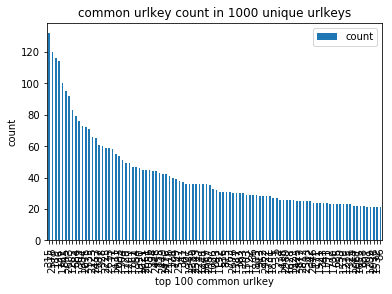

In [28]:
# plot common urlkey count bar chart
sums = np.sum(X_train, axis=0)
sums = pd.DataFrame(sums).transpose()
sums.columns=['count']
sums.sort_values(by=['count'], ascending=False)[:100].plot(kind='bar')
plt.title("common urlkey count in 1000 unique urlkeys")
plt.xlabel("top 100 common urlkey")
plt.ylabel("count")

In [31]:
# train agglomerative clustering model
model = AgglomerativeClustering(n_clusters = 10,  # number of target clusters, e.g. 10, 100
                                connectivity = None, # our problem is not a graph problem (or is it), no connectivity used
                                affinity='precomputed', # use jaccard distance metric to compute bit-wise similarity
                                linkage='average' # 'ward' is l2 distance, subject to curse
                               )
t0 = time.time()
model.fit(X_dist)
elapsed_time = time.time() - t0
print("time: ",elapsed_time)

time:  0.14736008644104004


In [32]:
# print silhouette_score
silhouette_score(X_dist, model.labels_, metric='precomputed')

0.01446837734238306

In [33]:
# train DBSCAN model
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.7, min_samples=6, metric='precomputed', n_jobs=-1)
t0 = time.time()
model.fit(X_dist)
elapsed_time = time.time() - t0
print("time: ",elapsed_time)

time:  0.05285000801086426


In [34]:
silhouette_score(X_dist, model.labels_, metric='precomputed')

0.085565785085076049

In [35]:
show_cluster_result(model)

#### cluster -1 with count: 435 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'adventure', 'entrepreneurship', 'social', 'socialnetwork', 'newintown', 'professional-networking', 'self-improvement'])
#### cluster 3 with count: 116 ####
dict_keys(['fun-times', 'professional-networking', 'diningout', 'adventure', 'entrepreneurship', 'outdoors', 'social', 'socialnetwork', 'newintown', 'self-improvement'])
#### cluster 7 with count: 111 ####
dict_keys(['fun-times', 'softwaredev', 'diningout', 'nightlife', 'livemusic', 'outdoors', 'social', 'newintown', 'socialnetwork', 'adventure'])
#### cluster 0 with count: 80 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'adventure', 'social', 'socialnetwork', 'excercise', 'newintown', 'newtech', 'self-improvement'])
#### cluster 4 with count: 46 ####
dict_keys(['fitness', 'sports', 'diningout', 'socialnetwork', 'singles', 'outdoors', 'newintown', 'computer-programming', 'fun-times', 'excercise'])
#### cluster 8 with count: 45 ####
dict_k

In [36]:
# use NMF to print most common topics

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from time import time

n_samples, n_features, n_topics, n_top_words = N_SAMPLES, 1000, N_TOPIC, N_KEYWORD

def print_top_words(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

def nmf_rsvp():
    '''
    Load the rsvp urlkeys dataset and vectorize it. We use a few heuristics
    to filter out useless terms early on: the posts are stripped of headers,
    footers and quoted replies, and common English words, words occurring in
    only one document or in at least 95% of the documents are removed.
    '''
    print("Loading dataset...")
    data_samples = pdf.all_text[:n_samples]

    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    nmf = NMF(n_components=n_topics, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nTopics in NMF model:")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)
    

nmf_rsvp()

Loading dataset...
Extracting tf-idf features for NMF...

Topics in NMF model:
Topic #0:
singles social 30s fun times socialnetwork diningout newintown professional dating
Topic #1:
business networking startup entrepreneurship marketing professional small strategy referral entrepreneur
Topic #2:
data analytics big science machine learning visualization predictive mining hadoop
Topic #3:
language exchange english culture spanish japanese expat international esl french
Topic #4:
self meditation improvement spiritual empowerment spirituality exploration healing wellness growth
Topic #5:
programming development web computer technology mobile softwaredev javascript android languages
Topic #6:
fitness hiking outdoor adventure sports outdoors adventures backpacking walkers excercise
Topic #7:
soccer pickupsoccer futbol coed indoor eurofootball sports game outdoor pickup
Topic #8:
games board strategy game cardgame night tabletop party euro gaming
Topic #9:
dance dancing art gallery partying p

### Make a dendrogram plot

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram
import sys
import matplotlib.pyplot as plt
%matplotlib inline

def jaccard(a,b):
    return DistanceMetric.get_metric('jaccard').pairwise(np.vstack([a,b]))[0,1]

n_samples = 1000
method = 'average'
metric = jaccard

dist_matrix = get_distance_matrix(X[:n_samples], metric)

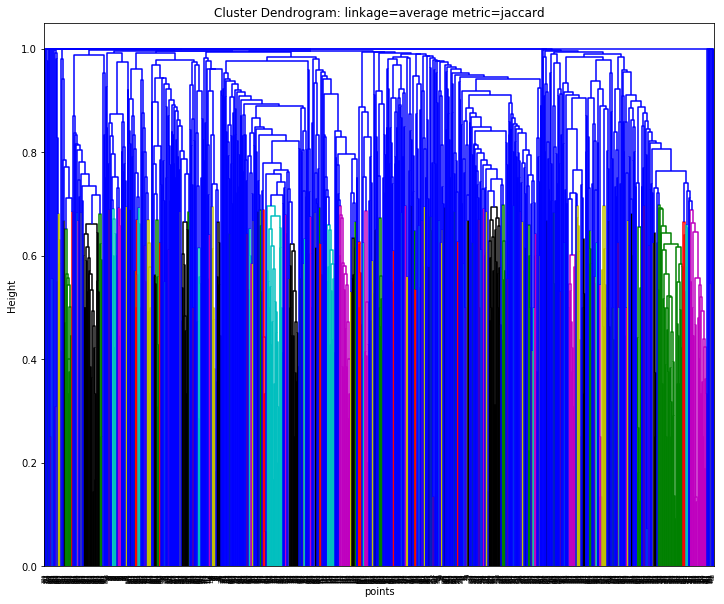

In [38]:
from scipy.spatial import distance

plt.figure(figsize=(12,10))
# get upper triangle items, stores in 1d array
ind_x, ind_y = np.triu_indices_from(dist_matrix, 1)
distxy = dist_matrix[ind_x, ind_y]
# distxy = distance.pdist(X_train, metric = 'euclidean')
# R = dendrogram(linkage(distxy, method=method, metric=metric), p=2, truncate_mode='level')
R = dendrogram(linkage(distxy, method=method))
plt.xlabel('points')
plt.ylabel('Height')
plt.title("Cluster Dendrogram: linkage={} metric={}".format(method, 'jaccard'))

In [39]:
color_list = np.array(R['color_list'])
leaves = np.array(R['leaves'])
pdf.urlkeys[leaves[color_list=='m']]

/Users/tristan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 999
  This is separate from the ipykernel package so we can avoid doing imports until


177    [opensource, python-web-development, functional-programming-in-python, functional-programming, a...
936    [beppegrillo, intellectual-discussion, liberta-di-informazione, democrazia-partecipativa, cittad...
976                                  [hiking, outdoors, outdoor-adventures, water-sports, mountain-biking]
978    [spanish, digcam, photo, photography-classes, portrait-photography, espanol, photo-walks, native...
322    [spanish, italian, french, german, portuguese, russian, arabic, exchangestud, language, japanese...
6                                                                 [walkers, volkssport, fitness, outdoors]
843    [gay, Lesbian, nightlife, lgbtfriends, outdoors, adventure, gay-and-lesbian-friends, outdoor-adv...
597    [filmind, screenwriters, indiefilm, acting, digcam, film, film-and-video-production, film-makers...
504    [art-galleries, creative, manga, sketching, draw, art, free-hand-drawing, drawing-for-beginners,...
861    [classics, intellectual-discus